Đánh giá Pipeline NER và RE

Notebook này thực hiện 2 nhiệm vụ chính:
1. Đánh giá riêng lẻ các mô hình RE (4 Vectorizers x 4 Models) trên Gold Standard Entities.
2. Đánh giá Pipeline kết hợp (NER -> RE): Dùng output của NER làm input cho RE.

In [1]:
# CELL 1: SETUP & IMPORTS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import joblib
from pathlib import Path

# Thêm path để import src
current_dir = Path(os.getcwd())
src_path = current_dir.parent / 'src'
sys.path.append(str(src_path))

from utils import MODEL_DIR, DATA_DIR
from evaluate import evaluate_all_models, evaluate_pipeline, inference_pipeline

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

PROCESSED_TEST_JSON = os.path.join(DATA_DIR, 'processed', 'test_tasks.json')
# Chọn model NER để đánh giá pipeline (spacy hoặc bert)
NER_MODEL_PATH = os.path.join(MODEL_DIR, 'ner_spacy_model')

c:\Users\ASUS\anaconda3\envs\mynewenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== ĐÁNH GIÁ 16 MÔ HÌNH RE (SUPERVISED) ===

--- BẮT ĐẦU ĐÁNH GIÁ TỔNG HỢP (Mode: STANDARD) ---
Checked: LogisticRegression + bow -> F1: 0.4772
Checked: SVM + bow -> F1: 0.4726
Checked: RandomForest + bow -> F1: 0.5425
Checked: MLPDeepLearning + bow -> F1: 0.5133
Checked: LogisticRegression + tfidf -> F1: 0.4316
Checked: SVM + tfidf -> F1: 0.4006
Checked: RandomForest + tfidf -> F1: 0.5291
Checked: MLPDeepLearning + tfidf -> F1: 0.4498
Applying scaler for w2v...
Checked: LogisticRegression + w2v -> F1: 0.3965
Checked: SVM + w2v -> F1: 0.2955
Checked: RandomForest + w2v -> F1: 0.3986
Checked: MLPDeepLearning + w2v -> F1: 0.4088
Applying scaler for bert...
Checked: LogisticRegression + bert -> F1: 0.5298
Checked: SVM + bert -> F1: 0.5131
Checked: RandomForest + bert -> F1: 0.4363
Checked: MLPDeepLearning + bert -> F1: 0.5990

Đã lưu bảng so sánh tại: D:\levy\Nam 3\NLP\medical-re - Copy\results\model_comparison.csv
BEST MODEL: MLPDeepLearning (bert) - F1: 0.5990


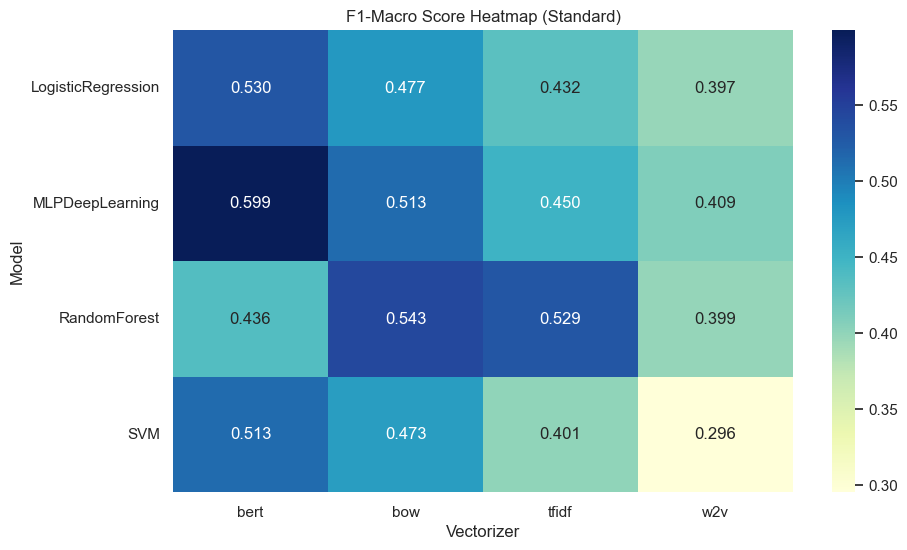

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24348\2158200959.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt, x='Model', y='Score', hue='Vectorizer', ci=None)


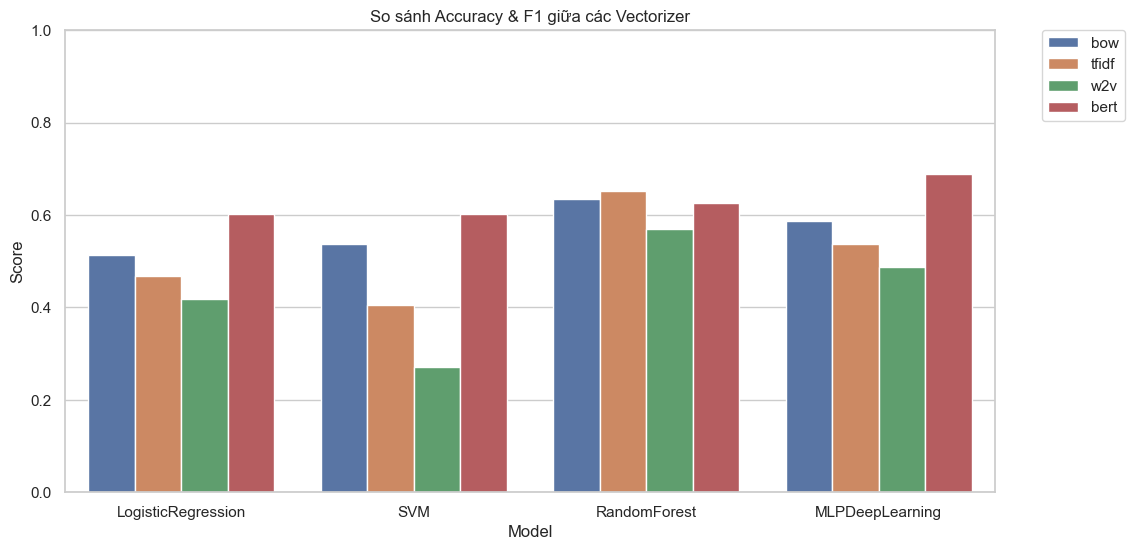

Best Standard Model: MLPDeepLearning using bert


In [2]:
# CELL 2: EVALUATE STANDARD RE MODELS
print("=== ĐÁNH GIÁ 16 MÔ HÌNH RE (SUPERVISED) ===")
# 1. Chạy đánh giá
df_standard, (best_vec, best_model) = evaluate_all_models(use_silver=False)

if not df_standard.empty:
    # 2. Vẽ Heatmap F1-Score
    pivot_table = df_standard.pivot(index="Model", columns="Vectorizer", values="F1_Macro")
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".3f")
    plt.title("F1-Macro Score Heatmap (Standard)")
    plt.show()

    # 3. Vẽ Grouped Bar Chart
    df_melt = df_standard.melt(id_vars=['Vectorizer', 'Model'], value_vars=['Accuracy', 'F1_Macro'], var_name='Metric', value_name='Score')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Model', y='Score', hue='Vectorizer', ci=None)
    plt.title("So sánh Accuracy & F1 giữa các Vectorizer")
    plt.ylim(0, 1.0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    print(f"Best Standard Model: {best_model} using {best_vec}")
else:
    print("Chưa có dữ liệu kết quả (Model chưa train).")

=== ĐÁNH GIÁ MÔ HÌNH RE HYBRID (SEMI-SUPERVISED) ===

--- BẮT ĐẦU ĐÁNH GIÁ TỔNG HỢP (Mode: HYBRID) ---
Checked: LogisticRegression + bow -> F1: 0.4820
Checked: SVM + bow -> F1: 0.4862
Checked: RandomForest + bow -> F1: 0.5192
Checked: MLPDeepLearning + bow -> F1: 0.4764
Checked: LogisticRegression + tfidf -> F1: 0.4114
Checked: SVM + tfidf -> F1: 0.4076
Checked: RandomForest + tfidf -> F1: 0.5163
Checked: MLPDeepLearning + tfidf -> F1: 0.4560
Applying scaler for w2v...
Checked: LogisticRegression + w2v -> F1: 0.3669
Checked: SVM + w2v -> F1: 0.3552
Checked: RandomForest + w2v -> F1: 0.3712
Checked: MLPDeepLearning + w2v -> F1: 0.4199
Applying scaler for bert...
Checked: LogisticRegression + bert -> F1: 0.5303
Checked: SVM + bert -> F1: 0.5419
Checked: RandomForest + bert -> F1: 0.4576
Checked: MLPDeepLearning + bert -> F1: 0.6081

Đã lưu bảng so sánh tại: D:\levy\Nam 3\NLP\medical-re - Copy\results\model_comparison_hybrid.csv
BEST MODEL: MLPDeepLearning (bert) - F1: 0.6081


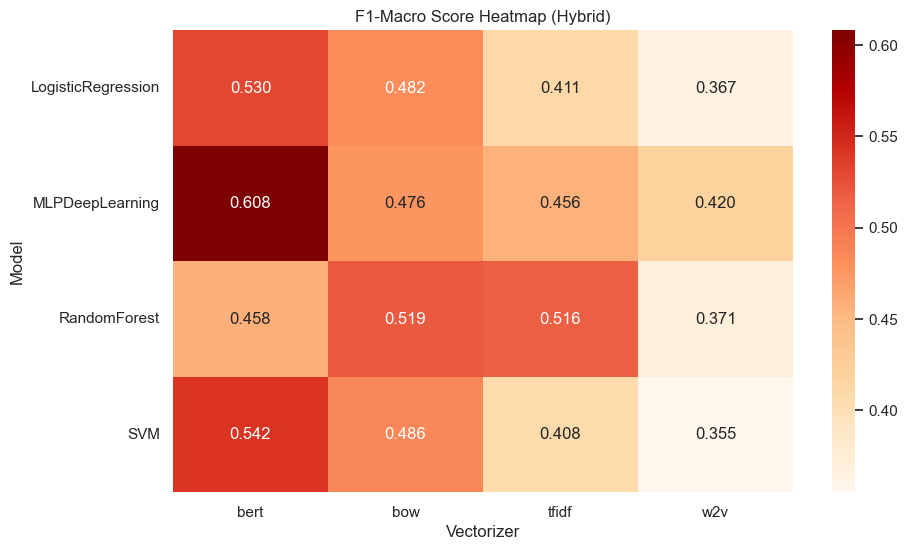

Best Hybrid Model: MLPDeepLearning using bert


In [3]:
# CELL 3: EVALUATE HYBRID RE MODELS
print("=== ĐÁNH GIÁ MÔ HÌNH RE HYBRID (SEMI-SUPERVISED) ===")
# 1. Chạy đánh giá với chế độ silver
df_hybrid, (best_vec_hybrid, best_model_hybrid) = evaluate_all_models(use_silver=True)

if not df_hybrid.empty:
    # 2. Vẽ Heatmap
    pivot_table_h = df_hybrid.pivot(index="Model", columns="Vectorizer", values="F1_Macro")
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table_h, annot=True, cmap="OrRd", fmt=".3f")
    plt.title("F1-Macro Score Heatmap (Hybrid)")
    plt.show()
    
    print(f"Best Hybrid Model: {best_model_hybrid} using {best_vec_hybrid}")
else:
    print("Chưa có dữ liệu Hybrid (Chưa chạy train với --use_silver hoặc chưa có file silver).")

=== SO SÁNH BEST STANDARD vs BEST HYBRID ===
        Type            Model Vectorizer  F1_Macro  Accuracy  Precision  \
15  Standard  MLPDeepLearning       bert  0.598995  0.780357   0.519222   
15    Hybrid  MLPDeepLearning       bert  0.608065  0.775000   0.521077   

      Recall  
15  0.759671  
15  0.796618  


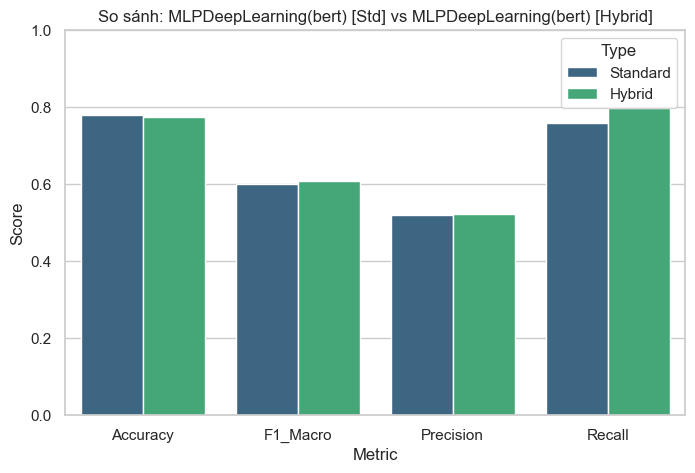

=> HYBRID MODEL CHIẾN THẮNG


In [4]:
# CELL 4: COMPARE BEST STANDARD vs BEST HYBRID
print("=== SO SÁNH BEST STANDARD vs BEST HYBRID ===")

if not df_standard.empty and not df_hybrid.empty:
    # Lấy row tốt nhất của mỗi bên
    best_row_std = df_standard[(df_standard['Model'] == best_model) & (df_standard['Vectorizer'] == best_vec)].copy()
    best_row_std['Type'] = 'Standard'
    
    best_row_hyb = df_hybrid[(df_hybrid['Model'] == best_model_hybrid) & (df_hybrid['Vectorizer'] == best_vec_hybrid)].copy()
    best_row_hyb['Type'] = 'Hybrid'
    
    df_compare = pd.concat([best_row_std, best_row_hyb])
    
    print(df_compare[['Type', 'Model', 'Vectorizer', 'F1_Macro', 'Accuracy', 'Precision', 'Recall']])
    
    # Vẽ biểu đồ so sánh 4 chỉ số
    df_compare_melt = df_compare.melt(id_vars=['Type'], value_vars=['Accuracy', 'F1_Macro', 'Precision', 'Recall'], var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_compare_melt, x='Metric', y='Score', hue='Type', palette='viridis')
    plt.title(f"So sánh: {best_model}({best_vec}) [Std] vs {best_model_hybrid}({best_vec_hybrid}) [Hybrid]")
    plt.ylim(0, 1.0)
    plt.show()
    
    # Chọn model chiến thắng cuối cùng để demo
    if best_row_hyb['F1_Macro'].values[0] > best_row_std['F1_Macro'].values[0]:
        final_best_model = best_model_hybrid
        final_best_vec = best_vec_hybrid
        final_use_silver = True
        print("=> HYBRID MODEL CHIẾN THẮNG")
    else:
        final_best_model = best_model
        final_best_vec = best_vec
        final_use_silver = False
        print("=> STANDARD MODEL CHIẾN THẮNG")
else:
    print("Thiếu dữ liệu để so sánh.")
    # Fallback
    final_best_model = best_model if not df_standard.empty else "RandomForest"
    final_best_vec = best_vec if not df_standard.empty else "bow"
    final_use_silver = False

In [5]:
# CELL 5: FULL PIPELINE EVALUATION
print("=== ĐÁNH GIÁ TOÀN BỘ PIPELINE (NER + RULE + RE) ===")
print(f"Sử dụng Model RE: {final_best_model} ({final_best_vec}) | Hybrid: {final_use_silver}")
print(f"Sử dụng Model NER: {NER_MODEL_PATH}")

f1_pipeline = evaluate_pipeline(
    PROCESSED_TEST_JSON, 
    NER_MODEL_PATH, 
    final_best_vec, 
    final_best_model, 
    use_silver=final_use_silver
)

=== ĐÁNH GIÁ TOÀN BỘ PIPELINE (NER + RULE + RE) ===
Sử dụng Model RE: MLPDeepLearning (bert) | Hybrid: True
Sử dụng Model NER: D:\levy\Nam 3\NLP\medical-re - Copy\models\ner_spacy_model

--- PIPELINE EVALUATION (Silver=True): NER + MLPDeepLearning (bert) ---
Loading SpaCy model from: D:\levy\Nam 3\NLP\medical-re - Copy\models\ner_spacy_model


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Result: Gold=94, Pred=108, Correct=49
Pipeline F1: 0.4851 (Precision=0.4537, Recall=0.5213)


In [7]:
# CELL 6: DEMO INFERENCE (HYBRID)
print("\n=== DEMO TRÍCH XUẤT QUAN HỆ TỪ VĂN BẢN THÔ ===")
input_text = "Chế độ ăn thiếu rau xanh, trái cây và lối sống ít vận động góp phần gây ra bệnh Alzheimer."

print(f"Input: {input_text}\n")

if final_best_model:
    try:
        entities, relations = inference_pipeline(
            input_text, 
            NER_MODEL_PATH, 
            final_best_vec, 
            final_best_model, 
            use_silver=final_use_silver
        )
        
        print("1. Thực thể tìm thấy (NER):")
        for ent in entities:
            print(f"   - [{ent['label']}] {ent['text']}")
            
        print("\n2. Quan hệ trích xuất được (Hybrid RE):")
        if relations:
            for rel in relations:
                print(f"   - {rel['subject']} --[{rel['relation']}]--> {rel['object']}")
        else:
            print("   Không tìm thấy quan hệ nào.")
            
    except Exception as e:
        print(f"Lỗi demo: {e}")
else:
    print("Chưa có model tốt nhất để demo.")


=== DEMO TRÍCH XUẤT QUAN HỆ TỪ VĂN BẢN THÔ ===
Input: Chế độ ăn thiếu rau xanh, trái cây và lối sống ít vận động góp phần gây ra bệnh Alzheimer.

Loading SpaCy model from: D:\levy\Nam 3\NLP\medical-re - Copy\models\ner_spacy_model
1. Thực thể tìm thấy (NER):
   - [Nguyên nhân] Chế độ ăn thiếu rau xanh, trái cây
   - [Nguyên nhân] lối sống ít vận động
   - [Bệnh] Alzheimer

2. Quan hệ trích xuất được (Hybrid RE):
   - Chế độ ăn thiếu rau xanh, trái cây --[Gây_ra]--> Alzheimer
   - lối sống ít vận động --[Gây_ra]--> Alzheimer
